# TO-DO: 
### Amortization Schedule -- make recurring loans a thing?. i.e. once lifetime of battery is up (mod lifetime battery), restart loan? 
 
### Rejig capital and finance costs (loan is not part of costs)
### Make sensitivity sliders?
### Grid Impact

# Notes 

We are aiming to hit a certain mileage at a certain weight + motor specs

if we have an equation that turns kWh into mileage, we could easily ask to input mileage 
and give 'kWh needed' as an output

in this equation would go the cars physical specs + motor specs, which would determine the vehicle's
efficiency (city & hwy)

we could ask for efficiency as input, and then output kWh needed, 
or we could ask for physical specs and output efficiencies, along with mileage, and have 'kWh needed' output

input mileage
input weight
determines kwh needed
determines kwh
detremines


Sliding graph where I slide kWh and it adjusts the cost of the retrofit

Interacts with a graph that adjusts the projected timeline (ie payback period) based on the cost of the retrofit

# To-Do

Figure out how to calculate the vehicle efficiencies based on Vincent's work, or like how far it can go for a certain kWh, and then make sliding graphs (using sample vehicle specs as fixed values) for desired mileage to kWh and cost


In [486]:
import pandas as pd
import numpy as np
import numpy_financial as npf
import matplotlib.pyplot as plt
import seaborn as sns

## Market Inputs (all in $USD unless otherwise noted)

In [452]:
years = np.arange(0,10) # years modeled

exch_rate = 15.79 #R15.79 to $1.00

price_diesel = 1.19 
price_electricity = 0.14 
price_charging = 0.30

mb_purchase_cost = 800000 / exch_rate 
cost_refurbish = 400000 / exch_rate

cost_opportunity_charging = 0
cost_carbon = 0  
cost_carbon_GR = 0.00 # %


## Loan Inputs

rate_interest = 0.225 # Avg Rate from Integrate Capital Report, range of 14.5 to 26.75 (vincent suggests 28%?) 
loan_lifetime = 4
payments_per_year = 4

## Vehicle Inputs

In [453]:
FE_hwy_EV, FE_urban_EV = 5.5, 4 #km/kWh

FE_hwy_ICE, FE_urban_ICE = 10, 12 #L/100km

km_morning = km_evening = 225 # km
km_daily = km_morning + km_evening
days_worked_driver = 320 #days/yr
km_annual = days_worked_driver * km_daily 
 
perc_miles_city = 0.80 # %

cost_insurance_EV = cost_insurance_ICE = 200 # $/yr

cost_taxes_fees_EV = cost_taxes_fees_ICE = 10 # $/yr

cost_maintenance_EV = cost_maintenance_ICE = 3500 #$/yr

expected_ownership_EV, expected_ownership_ICE = 10, 4 #yrs

lifetime_retrofit = 10 # yrs
hrs_daily_charging = 4 #hrs

# Retrofit Costs ($USD)

#### Battery Pack

In [490]:
amp_hrs = 206

if amp_hrs == 228:
#Unit Size 
    length_cell, width_cell, depth_cell = 207.1, 174.6, 53.8 #mm
    weight_cell = 4.2 # kg
    voltage_cell = 3.65
elif amp_hrs == 206:
    length_cell, width_cell, depth_cell = 200, 174.0, 53.7 #mm
    weight_cell = 4.1 # kg 
    voltage_cell = 3.22
#Unit Energy

kWh = voltage_cell * amp_hrs / 10**3 # kWh

#Unit cost
amp_cost = 0.62 # $/Ah
cost_cell = amp_hrs * amp_cost
num_cells = 130 # fixing num_cells instead of energy needed

volume_cell = length_cell * width_cell * depth_cell / 10**6 # L

#Pack specs
weight_pack = weight_cell * num_cells #kg
volume_pack = volume_cell * num_cells #L
kwh_pack = kWh * num_cells #kWh
cost_pack = cost_cell * num_cells #$

print("Energy (kWh):", kwh_pack, "\n", "Cost (USD):", "${:,.2f}".format(cost_pack), "\n", 
      "Weight (kg):", weight_pack, "\n", "Size (L):", vol_pack)

Energy (kWh): 86.2316 
 Cost (USD): $16,603.60 
 Weight (kg): 533.0 
 Size (L): 242.9388


#### E-Motor, Drive, Charger

In [455]:

weight_motor = 68 #kg
torque_motor = 220 #Nm
power_motor = 82 #kW
speed_motor = 3580 #rpm
phase_rms_current_motor = 218 # A
voltageDC_motor = 400 #V
elec_freq_motor = 298 #Hz
power_factor_motor = 0.72

#Dimensions
rad_motor, depth_motor = 165, 336 # mm
vol_motor = depth_motor * np.pi * rad_motor**2  # L

cost_motor = 5000

#### Drive, Charger

In [456]:
cost_drive = 5100
cost_charger = 3000

#### Controls

In [457]:
cost_masterboard, cost_slaveboard = 250, 200

#### Other

In [458]:
cost_telematics = 200
cost_misc = 50 # wiring, etc
cost_other = cost_telematics + cost_misc

#### Cost of Labor

In [459]:
hours_retrofit = 20 #hrs
wage_retrofit = 50 # $/hr
cost_retrofit_labor = hours_retrofit * wage_retrofit

### Total

In [460]:
cost_retrofit = cost_pack + cost_motor + cost_drive + cost_charger + cost_other + cost_retrofit_labor

## Fuel Cost

In [475]:
# Assuming fuel cost same each year
cost_fuel_EV = np.full(len(years), price_charging * km_annual * (perc_miles_city * (1/FE_urban_EV) + (1 - perc_miles_city)  * (1/FE_hwy_EV))) # same fuel cost every year 
cost_fuel_EV[0] = 0

In [476]:
cost_fuel_ICE = np.full(len(years), price_diesel * km_annual * ((perc_miles_city * (FE_urban_ICE/100)  + (1 - perc_miles_city) * (FE_hwy_ICE/100))))
cost_fuel_ICE[0] = 0 # 0 in year 0 

## Operating Cost

In [477]:
cost_operating_EV = np.full(len(years), cost_insurance_EV + cost_maintenance_EV + cost_taxes_fees_EV )
cost_operating_EV[0] = 0

In [478]:
cost_operating_ICE = np.full(len(years), cost_insurance_ICE + cost_maintenance_ICE + cost_taxes_fees_ICE)
cost_operating_ICE[0] = 0

## Capital And Financing Cost

In [465]:
# function code sourced from here: https://www.christopheryee.org/blog/build-a-loan-amortization-schedule-with-python/
def amortization_schedule(rate_int, loan_amount, years): 

  ##### PARAMETERS #####  
    loan_amount = -loan_amount
    rate_interest = rate_int / 12
    periods = years * 12 # monthly payback
    n_periods = np.arange(periods) + 1
  
  ##### BUILD AMORTIZATION SCHEDULE #####
  # Interest 
    interest_monthly = npf.ipmt(rate_interest, n_periods, periods, loan_amount)
  
  # Principal 
    principal_monthly = npf.ppmt(rate_interest, n_periods, periods, loan_amount)
  
  # JOIN DATA
    df_initialize = list(zip(n_periods, interest_monthly, principal_monthly))
    df = pd.DataFrame(df_initialize, columns=['Period','Interest','Principal'])
  
  # Monthly Loan Payment
    df['Payment'] = df['Interest'] + df['Principal']
  
  # Cumsum Loan Payments
    df['Balance'] = df['Payment'].cumsum()
  
  # Reverse vals to pay down balance
    df.Balance = df.Balance.values[::-1]
  
    return(df)

In [466]:
amortization_schedule_retrofit = amortization_schedule(rate_interest, cost_retrofit, loan_lifetime)
amortization_schedule_refurbish = amortization_schedule(rate_interest, cost_refurbish, loan_lifetime)

In [491]:
annual_loan_payment_retrofit = np.round(amortization_schedule_retrofit.iloc[0:12].sum()['Payment'],2) #is the same for 
annual_loan_payment_refurbish = np.round(amortization_schedule_refurbish.iloc[0:12].sum()['Payment'],2) #is the 
print("Refurbishment annual loan payment ($):", annual_loan_payment_refurbish,"\n", "Retrofit annual loan payment ($):", annual_loan_payment_retrofit)

Refurbishment annual loan payment ($): 9660.24 
 Retrofit annual loan payment ($): 11803.78


In [468]:
#Retrofit Loan Payback Schedule
cap_fin_cost_EV = np.zeros(len(years))
cap_fin_cost_EV[0] = -cost_retrofit #negative because the loan is a cash inflow
cap_fin_cost_EV[1:loan_lifetime+1] = annual_loan_payment_retrofit

#Refurbishment Loan Payback Schedule Schedule
cap_fin_cost_ICE = np.zeros(len(years))
cap_fin_cost_ICE[0] = -cost_refurbish #negative because the loan is a cash inflow
cap_fin_cost_ICE[1:loan_lifetime+1] = annual_loan_payment_refurbish

cap_fin_cost_EV, cap_fin_cost_ICE

(array([-30953.6      ,  11803.7780393,  11803.7780393,  11803.7780393,
         11803.7780393,      0.       ,      0.       ,      0.       ,
             0.       ,      0.       ]),
 array([-25332.48891704,   9660.23584849,   9660.23584849,   9660.23584849,
          9660.23584849,      0.        ,      0.        ,      0.        ,
             0.        ,      0.        ]))

# Total Costs

#### Total Annual Costs 

In [469]:
cost_annual_EV = cost_operating_EV + cost_fuel_EV + cap_fin_cost_EV 
cost_annual_ICE = cost_operating_ICE + cost_fuel_ICE + cap_fin_cost_ICE 
print(cost_annual_EV,"\n",cost_annual_ICE) #sanity checks

[-30953.6         25724.68713021  25724.68713021  25724.68713021
  25724.68713021  13920.90909091  13920.90909091  13920.90909091
  13920.90909091  13920.90909091] 
 [-25332.48891704  33247.99584849  33247.99584849  33247.99584849
  33247.99584849  23587.76        23587.76        23587.76
  23587.76        23587.76      ]


#### Discount Factor

In [470]:
rate_discount = 0.08 
factor_discount = np.empty(len(years))
for t in years:
    factor_discount[t] = 1/(1 * (1 + rate_discount)**t)

#### Discounted Costs

In [471]:
cost_annual_discounted_EV = np.empty(len(years))
cost_annual_discounted_ICE = np.empty(len(years))
for t in years:
    cost_annual_discounted_EV[t], cost_annual_discounted_ICE[t] = cost_annual_EV[t] * factor_discount[t], cost_annual_ICE[t] * factor_discount[t]

print(cost_annual_discounted_EV,"\n",cost_annual_discounted_ICE)

[-30953.6         23819.1547502   22054.77291685  20421.08603412
  18908.41299456   9474.33681471   8772.53408769   8122.71674786
   7521.0340258    6963.92039426] 
 [-25332.48891704  30785.18134119  28504.79753814  26393.33105384
  24438.26949429  16053.43311166  14864.28991821  13763.23140575
  12743.7327831   11799.75257694]


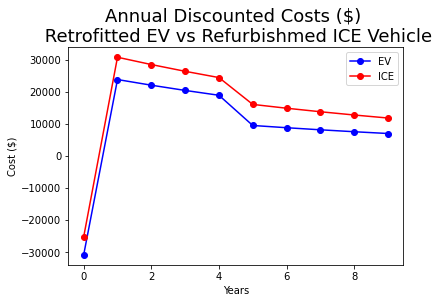

In [472]:
plt.title("Annual Discounted Costs ($) \n Retrofitted EV vs Refurbishmed ICE Vehicle", size = 18)
plt.xlabel("Years")
plt.ylabel("Cost ($)")
plt.plot(years, cost_annual_discounted_EV, color = 'blue', label = 'EV', marker = 'o')
plt.plot(years, cost_annual_discounted_ICE, color = 'red', label = 'ICE', marker = 'o')
plt.legend()
plt.show()

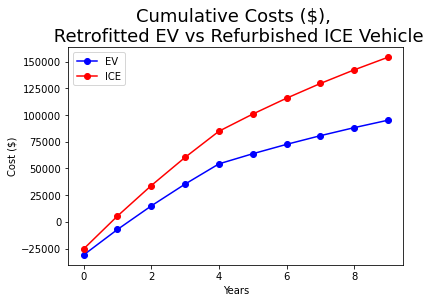

In [473]:
plt.title("Cumulative Costs ($), \n Retrofitted EV vs Refurbished ICE Vehicle", size = 18)
plt.xlabel("Years")
plt.ylabel("Cost ($)")
plt.plot(years, np.cumsum(cost_annual_discounted_EV), color = 'blue', label = 'EV', marker = 'o')
plt.plot(years, np.cumsum(cost_annual_discounted_ICE), color = 'red', label = 'ICE', marker = 'o')
plt.legend()
plt.show()

## Test Interactive Graph

In [474]:
from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

In [493]:
def myfunc(x):
    plt.plot(np.arange(0,10), x * np.arange(0,10))
    plt.ylim(-30,30)
interact(myfunc, x = 3)

interactive(children=(IntSlider(value=3, description='x', max=9, min=-3), Output()), _dom_classes=('widget-int…

<function __main__.myfunc(x)>